COMP9444(Resnet18 & Resnet34 On Mask Protection)

*Introduction and problem statement: This is a CV project that using resnet to train a binary task(mask, no mask).In this project we build up data enhancement, datasets, dataloader, train structure(train test loop, optimizer, loss function and figure plot) and test alexnet, resnet34 and resnet18 with different set up(learning rate, optimizer, datasets volume...) to explore the performance in this task.
*Data Sources: we use total 4008 different color images, 3008 images for train(1504 mask 1504 no mask), 500 images for test(250 mask 250 no mask) and 500 images for validation(250 mask 250 no mask, although we don't validate it), the data source link is here: https://www.kaggle.com/datasets/prasoonkottarathil/face-mask-lite-dataset
*Exploratory Analysis of Data:
    1.Transforms(This is data enhancement, we use cropping, flipping, rotation, color changing, and normalize to enhance the data in order to increase generalization capability and prevent over fitting)
    2.Datasets & DataLoaders(we transform data into dataloader, the dataloader include X(picture matrix) and y(one hot coding of mask or no maks))
    3.NeuralNetwork(provide resnet18, resnet34 and alexnet initialization, it's also print the details of the network to check)
    4.Device(can run on GPU, if not run on CPU)
    5.Train and Test Loop(get the data from dataloader and do the training and testing)
    6.Optimizing Model Parameters(optimizer and loss function initialization)
    7.Plot function(plot the test acc and loss)
    8.Fit function(In epochs loops, call 4,5,6,7 functions or parameters)
    9.Testing(test resnet34 and resnet18 with different set up(learning rate, optimizer, datasets volume...))
    The most challenging aspect is to avoid over fitting,if the images of acc and loss oscillate too much repeatedly, it may mean that the model is over fitted,to prevent over fitting, we try to use different data sources, increase data volume, increase data enhancement and adjust learning rate and optimizer to test.
*Models and/or Methods:We use the residual network model alexnet, resnet18 and resnet34. We retain the previous layer and only train the final output linear layer.We used the training method recommended by the official website of Pytorch (use the model to calculate the predictive value in the train loop, and put the actual value into the loss method to calculate the loss value, use the optimizer to adjust the parameters for gradient descent, and for test loop, only calculate the accuracy and loss value)
*Results and Discussion is at the 9.Testing

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

1.Transforms

In [2]:
'''
Transforms(Data enhancement)
'''
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
data_transforms = {
    'Train': transforms.Compose([
        # Can add more
        transforms.CenterCrop(224), # center crop 224*224 for resnet
        transforms.RandomHorizontalFlip(p=0.5), # Random horizontal rollover with a probability of 0.5
        transforms.RandomRotation(45), # random rotate -45°-45°
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1), # 亮度，对比度，饱和度，色相
        transforms.RandomGrayscale(p=0.025), # 随机变灰
        transforms.ToTensor(), # Transfer to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Treatment of mean and standard deviation
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5), # Random horizontal rollover with a probability of 0.5
        transforms.RandomRotation(45), # random rotate-45°-45°
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1), # 亮度，对比度，饱和度，色相
        transforms.RandomGrayscale(p=0.025),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
}

2.Datasets & DataLoaders

In [3]:
'''
Datasets class
'''
class ImageDataset:
    def __init__(self, img_dir, data_transform):
        self.img_dir = img_dir
        self.transform = data_transform
        self.datasets_dict = {}
        self.folder = ['Train', 'Test']
    def make_datasets(self):
        for sets_type in self.folder:
            self.datasets_dict[sets_type] = datasets.ImageFolder(os.path.join(self.img_dir, sets_type), data_transforms[sets_type])
        return self.datasets_dict

In [4]:
'''
DataLoader function
'''
def dataloader(img_dataset):
    data_loader = {}
    for x in list(img_dataset.keys()):
        data_loader[x] = torch.utils.data.DataLoader(img_dataset[x], batch_size=4, shuffle=True)
    return data_loader

In [5]:
# define a function can view the picture in dataloader
def img_show(img_loader, img_sets):
    for i in list(img_loader.keys()):
        inputs, classes = next(iter(data_loader[i]))
        out = torchvision.utils.make_grid(inputs)
        image = out.numpy().transpose((1, 2, 0))
        image = image * np.array((0.229, 0.224, 0.225) + np.array((0.485, 0.456, 0.406)))
        image = image.clip(0, 1)
        plt.imshow(image)
        title = [img_sets[i].classes[x] for x in classes]
        plt.title(title)
        plt.pause(0.001)

In [6]:
# set up a datasets
img_dir = "Set"
sets = ImageDataset(img_dir, data_transforms).make_datasets()
data_loader = dataloader(sets)

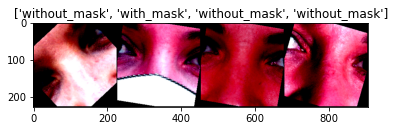

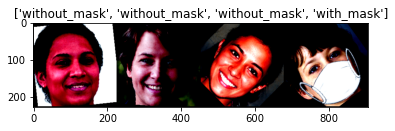

In [7]:
img_show(data_loader, sets) # if set up bath to a single digit, it's easier to see the img in the data loader

3.NeuralNetwork

In [8]:
'''
Network class:
    can only support resnet18, resnet34 and alexnet
'''
class Network:
    def __init__(self, network_type, feature_extract):
        self.net_type = network_type
        self.feature_extract = feature_extract


    def get_network(self):
        model_ft = ""
        if self.net_type == "resnet18":
            model_ft = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        elif self.net_type == "resnet34":
            model_ft = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.IMAGENET1K_V1)
        elif self.net_type == "alexnet":
            model_ft = torchvision.models.alexnet(weights=torchvision.models.AlexNet_Weights.DEFAULT)
        elif self.net_type == "vgg11":
            model_ft = torchvision.models.vgg11(weights=torchvision.models.VGG11_Weights.DEFAULT)
        # whether to use original para
        if self.feature_extract:
            for param in model_ft.parameters():
                param.requires_grad = False
        # change the output layer
        if self.net_type == "resnet18" or self.net_type == "resnet34":
            num_features = model_ft.fc.in_features
            model_ft.fc = nn.Linear(num_features, 2)
        elif self.net_type == "alexnet" or self.net_type == "vgg11":
            model_ft.classifier._modules['6'] = nn.Linear(4096, 2)

        if model_ft == "":
            print("Sorry don't have this network yet!")
        else:
            print(model_ft)
            print("-"*20)
            print("parameters need to learn:")
            for name, param in model_ft.named_parameters():
                if param.requires_grad:
                    print("\t", name)
        return model_ft



In [9]:
resnet18 = Network("resnet18", True).get_network()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
resnet34 = Network("resnet34", True).get_network()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
alexnet = Network("alexnet", True).get_network()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [12]:
vgg11 = Network("vgg11", True).get_network()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

4.Device

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
def check_device():
    if torch.cuda.is_available():
        print("Start on GPU")
    else:
        print("Start on CPU")

5.Train and Test Loop

In [15]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.to(device)
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        # grad,backward,optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, out_pred = torch.max(model(X), 1)
        # collect some value can output
        if batch % 2 == 0:
            loss, current = loss.item(), batch * len(X)

            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            # if you want to check predict and real value, run this
            # print(f"predict:{out_pred}\n, real:{y}")

def test_loop(dataloader, model, loss_fn, corr_list, test_loss_list):
    model.to(device)
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # collect some value can output
    test_loss /= num_batches
    correct /= size
    corr_list.append(correct*100)
    test_loss_list.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

6.Optimizing Model Parameters

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer_resnet18 = optim.SGD(resnet18.parameters(), lr=0.0001, momentum=0.1)
optimizer_resnet34 = optim.Adam(resnet34.parameters(), lr=0.0001)
optimizer_alexnet = optim.SGD(alexnet.parameters(), lr=0.0005)
optimizer_vgg11 = optim.Adam(vgg11.parameters(), lr=0.0001)

7.Plot function

In [17]:
def draw_result(figure, epoch_time, tittle, y_label, x_label):
    y = np.array(figure)
    x = np.array(epoch_time)
    plt.plot(x, y)

    plt.title(tittle)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()

8.Fit function

In [18]:
def fit(epoch, resnet, loss_function, optimizer):
    corr_list, test_loss_list = [], []
    check_device()
    for t in range(epoch):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(data_loader["Train"], resnet, loss_function, optimizer)
        test_loop(data_loader["Test"], resnet, loss_function, corr_list, test_loss_list)
    draw_result(corr_list, [i for i in range(1, len(corr_list)+1)], "Accuracy result", "Accuracy(%)", "epoch")
    draw_result(test_loss_list, [i for i in range(1, len(test_loss_list)+1)], "Loss result", "Loss", "epoch")
    print("Done!")

----------------------------------------------9.TESTING(*Result)----------------------------------------------------------------

Test1  experimental group(try to test with a lower data volume)
(Resnet18, epoch=50, optimizer=Adam lr0.0001, loss_function=CrossEntropyLoss, Train dataset volume=2008)
Compare with test2, the increase speed of test 1 accuracy will be slower, and the decrease speed of loss value will become full, but there is no significant difference between the highest accuracy value and the lowest loss value.

Start on CPU
Epoch 1
-------------------------------
loss: 0.997873  [    0/ 2008]
loss: 0.953247  [  512/ 2008]
loss: 0.910179  [ 1024/ 2008]
loss: 0.850814  [ 1536/ 2008]
Test Error: 
 Accuracy: 44.0%, Avg loss: 0.876482 

Epoch 2
-------------------------------
loss: 0.836567  [    0/ 2008]
loss: 0.848791  [  512/ 2008]
loss: 0.796800  [ 1024/ 2008]
loss: 0.816760  [ 1536/ 2008]
Test Error: 
 Accuracy: 33.8%, Avg loss: 0.807593 

Epoch 3
-------------------------------
loss: 0.810033  [    0/ 2008]
loss: 0.786476  [  512/ 2008]
loss: 0.789242  [ 1024/ 2008]
loss: 0.791403  [ 1536/ 2008]
Test Error: 
 Accuracy: 35.5%, Avg loss: 0.805432 

Epoch 4
-------------------------------
loss: 0.760789  [    0/ 2008]
loss: 0.745786  [  512/ 2008]
loss: 0.784733  [ 1024/ 2008]
loss: 0.777233  [ 1536/ 2008]
Test Error: 
 Accuracy: 40.2%, Avg loss: 0.773458 

Epoch 5
-------------------------------
loss: 0.763244  [    0/ 2008]
loss: 0.743971  [  512/ 2008]
loss: 0.722649  [ 1024/ 2008]
loss: 0.7

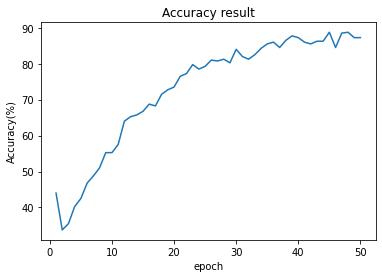

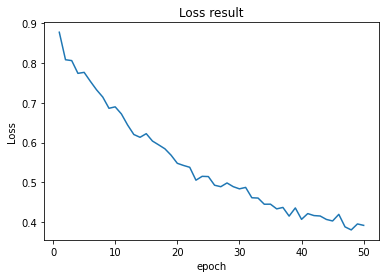

Done!


In [31]:
fit(50, resnet18, loss_fn, optimizer_resnet18)

Test2 Control group.
(Resnet18 epoch=50 optimizer=Adam lr0.0001 loss_function=CrossEntropyLoss dataset_volume=3008)

Start on CPU
Epoch 1
-------------------------------
loss: 0.665839  [    0/ 3008]
loss: 0.661167  [  512/ 3008]
loss: 0.636490  [ 1024/ 3008]
loss: 0.641574  [ 1536/ 3008]
loss: 0.614802  [ 2048/ 3008]
loss: 0.621395  [ 2560/ 3008]
Test Error: 
 Accuracy: 38.4%, Avg loss: 0.762403 

Epoch 2
-------------------------------
loss: 0.589779  [    0/ 3008]
loss: 0.586418  [  512/ 3008]
loss: 0.606531  [ 1024/ 3008]
loss: 0.574572  [ 1536/ 3008]
loss: 0.563577  [ 2048/ 3008]
loss: 0.588765  [ 2560/ 3008]
Test Error: 
 Accuracy: 48.7%, Avg loss: 0.730514 

Epoch 3
-------------------------------
loss: 0.554855  [    0/ 3008]
loss: 0.533805  [  512/ 3008]
loss: 0.555940  [ 1024/ 3008]
loss: 0.541718  [ 1536/ 3008]
loss: 0.530988  [ 2048/ 3008]
loss: 0.513677  [ 2560/ 3008]
Test Error: 
 Accuracy: 46.9%, Avg loss: 0.730326 

Epoch 4
-------------------------------
loss: 0.519798  [    0/ 3008]
loss: 0.512457  [  512/ 3008]
loss: 0.510102  [ 1024/ 3008]
loss: 0.488593  [ 1536/ 3008]
loss: 0.472

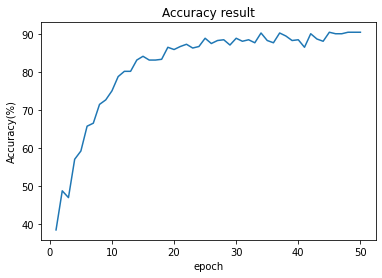

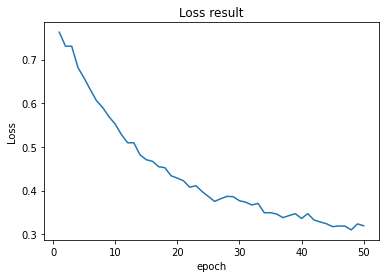

Done!


In [49]:
fit(50, resnet18, loss_fn, optimizer_resnet18)

Test3 experimental group(Try if add learning rate).
(Resnet18, epoch=50, optimizer=Adam lr0.001, loss_function=CrossEntropyLoss, Train dataset volume=3008)
Compared with Test 2, the image of accuracy and loss value fluctuates significantly, and the learning of accuracy value increases rapidly. It seems that the climbing of accuracy value has been skipped in the image, and it is directly improved to 88.7%.

Start on CPU
Epoch 1
-------------------------------
loss: 0.702680  [    0/ 3008]
loss: 0.701690  [  512/ 3008]
loss: 0.567292  [ 1024/ 3008]
loss: 0.568947  [ 1536/ 3008]
loss: 0.497644  [ 2048/ 3008]
loss: 0.452737  [ 2560/ 3008]
Test Error: 
 Accuracy: 88.7%, Avg loss: 0.449196 

Epoch 2
-------------------------------
loss: 0.474101  [    0/ 3008]
loss: 0.420806  [  512/ 3008]
loss: 0.390553  [ 1024/ 3008]
loss: 0.335942  [ 1536/ 3008]
loss: 0.357040  [ 2048/ 3008]
loss: 0.292553  [ 2560/ 3008]
Test Error: 
 Accuracy: 90.3%, Avg loss: 0.374632 

Epoch 3
-------------------------------
loss: 0.282154  [    0/ 3008]
loss: 0.287962  [  512/ 3008]
loss: 0.236647  [ 1024/ 3008]
loss: 0.228402  [ 1536/ 3008]
loss: 0.246739  [ 2048/ 3008]
loss: 0.195483  [ 2560/ 3008]
Test Error: 
 Accuracy: 88.7%, Avg loss: 0.335495 

Epoch 4
-------------------------------
loss: 0.210891  [    0/ 3008]
loss: 0.200815  [  512/ 3008]
loss: 0.189026  [ 1024/ 3008]
loss: 0.178347  [ 1536/ 3008]
loss: 0.172

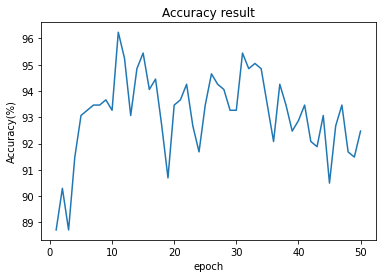

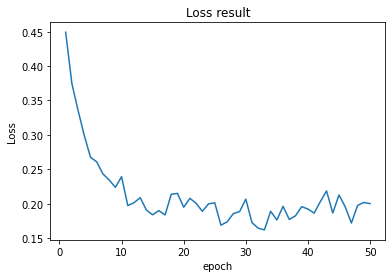

Done!


In [67]:
fit(50, resnet18, loss_fn, optimizer_resnet18)

Test4 experimental groupTry (try if use SGD).
(Resnet18, epoch=50, optimizer=SGD lr0.0001 mon=0.1, loss_function=CrossEntropyLoss, train dataset volume=3008)
The same as test4 is the accuracy of the model increases rapidly, and the loss value decreases rapidly. However, the accuracy fluctuates between 94.5-91, and the fluctuation range is half of test4.

Start on CPU
Epoch 1
-------------------------------
loss: 0.014260  [    0/ 3008]
loss: 0.012492  [  512/ 3008]
loss: 0.015880  [ 1024/ 3008]
loss: 0.010835  [ 1536/ 3008]
loss: 0.010486  [ 2048/ 3008]
loss: 0.009382  [ 2560/ 3008]
Test Error: 
 Accuracy: 92.9%, Avg loss: 0.194349 

Epoch 2
-------------------------------
loss: 0.017736  [    0/ 3008]
loss: 0.012660  [  512/ 3008]
loss: 0.011972  [ 1024/ 3008]
loss: 0.007724  [ 1536/ 3008]
loss: 0.009451  [ 2048/ 3008]
loss: 0.012485  [ 2560/ 3008]
Test Error: 
 Accuracy: 94.5%, Avg loss: 0.171774 

Epoch 3
-------------------------------
loss: 0.007048  [    0/ 3008]
loss: 0.011468  [  512/ 3008]
loss: 0.011309  [ 1024/ 3008]
loss: 0.018711  [ 1536/ 3008]
loss: 0.012967  [ 2048/ 3008]
loss: 0.012651  [ 2560/ 3008]
Test Error: 
 Accuracy: 91.7%, Avg loss: 0.208880 

Epoch 4
-------------------------------
loss: 0.012671  [    0/ 3008]
loss: 0.009894  [  512/ 3008]
loss: 0.010030  [ 1024/ 3008]
loss: 0.009875  [ 1536/ 3008]
loss: 0.010

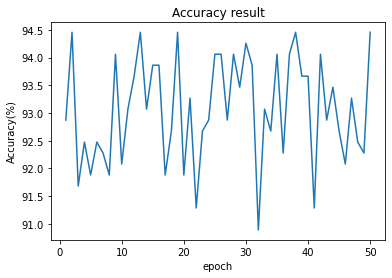

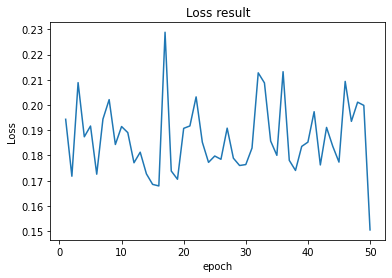

Done!


In [73]:
fit(50, resnet18, loss_fn, optimizer_resnet18)

Test5 experimental groupTry(Try if use resnet34)
(Resnet34 epoch=50 optimizer=Adam lr0.0001 loss_function=CrossEntropyLoss dataset_volume=3008)
Compared with the test2 image, the vibration is more obvious. The model may be over fitted, and the same learning rate may be a little high for resnet34.

Start on CPU
Epoch 1
-------------------------------
loss: 0.738052  [    0/ 3008]
loss: 0.708985  [  512/ 3008]
loss: 0.737927  [ 1024/ 3008]
loss: 0.691584  [ 1536/ 3008]
loss: 0.642181  [ 2048/ 3008]
loss: 0.656033  [ 2560/ 3008]
Test Error: 
 Accuracy: 58.2%, Avg loss: 0.650447 

Epoch 2
-------------------------------
loss: 0.687585  [    0/ 3008]
loss: 0.661301  [  512/ 3008]
loss: 0.641440  [ 1024/ 3008]
loss: 0.655422  [ 1536/ 3008]
loss: 0.650678  [ 2048/ 3008]
loss: 0.646027  [ 2560/ 3008]
Test Error: 
 Accuracy: 63.0%, Avg loss: 0.631456 

Epoch 3
-------------------------------
loss: 0.640810  [    0/ 3008]
loss: 0.636711  [  512/ 3008]
loss: 0.626996  [ 1024/ 3008]
loss: 0.612512  [ 1536/ 3008]
loss: 0.599259  [ 2048/ 3008]
loss: 0.618306  [ 2560/ 3008]
Test Error: 
 Accuracy: 66.5%, Avg loss: 0.617645 

Epoch 4
-------------------------------
loss: 0.601107  [    0/ 3008]
loss: 0.601240  [  512/ 3008]
loss: 0.591929  [ 1024/ 3008]
loss: 0.544291  [ 1536/ 3008]
loss: 0.575

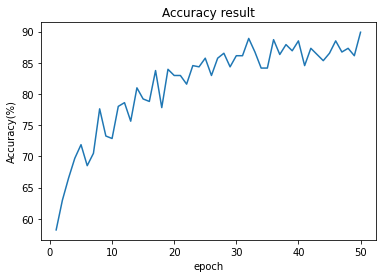

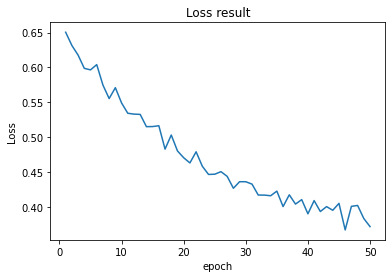

Done!


In [71]:
fit(50, resnet34, loss_fn, optimizer_resnet34)

Test6 experimental groupTry(Try if use alexnet)
(alexnet epoch=50 optimizer=Adam lr0.0001 loss_function=CrossEntropyLoss dataset_volume=3008)

In [ ]:
fit(50, alexnet, loss_fn, optimizer_resnet18)

Start on CPU
Epoch 1
-------------------------------
loss: 0.793812  [    0/ 3008]
loss: 0.782531  [  512/ 3008]
loss: 0.747530  [ 1024/ 3008]
loss: 0.800471  [ 1536/ 3008]
loss: 0.742107  [ 2048/ 3008]
loss: 0.822823  [ 2560/ 3008]
Test Error: 
 Accuracy: 29.8%, Avg loss: 0.926167 

Epoch 2
-------------------------------
loss: 0.779502  [    0/ 3008]
loss: 0.780769  [  512/ 3008]
loss: 0.785378  [ 1024/ 3008]
loss: 0.792205  [ 1536/ 3008]
loss: 0.772723  [ 2048/ 3008]
loss: 0.756789  [ 2560/ 3008]
Test Error: 
 Accuracy: 31.8%, Avg loss: 0.897080 

Epoch 3
-------------------------------
loss: 0.770076  [    0/ 3008]
loss: 0.770077  [  512/ 3008]
loss: 0.816712  [ 1024/ 3008]
loss: 0.788650  [ 1536/ 3008]
loss: 0.805232  [ 2048/ 3008]
loss: 0.764690  [ 2560/ 3008]
Test Error: 
 Accuracy: 29.6%, Avg loss: 0.895345 

Epoch 4
-------------------------------
loss: 0.781010  [    0/ 3008]
loss: 0.770042  [  512/ 3008]
loss: 0.802243  [ 1024/ 3008]
loss: 0.792590  [ 1536/ 3008]
loss: 0.783

Start on CPU
Epoch 1
-------------------------------
loss: 0.937465  [    0/ 3008]
loss: 0.681052  [    8/ 3008]
loss: 0.685356  [   16/ 3008]
loss: 0.800117  [   24/ 3008]
loss: 0.853721  [   32/ 3008]
loss: 0.650955  [   40/ 3008]
loss: 0.534044  [   48/ 3008]
loss: 0.907226  [   56/ 3008]
loss: 0.710679  [   64/ 3008]
loss: 0.616000  [   72/ 3008]
loss: 0.658491  [   80/ 3008]
loss: 0.528445  [   88/ 3008]
loss: 0.519688  [   96/ 3008]
loss: 0.661829  [  104/ 3008]
loss: 0.715554  [  112/ 3008]
loss: 0.724338  [  120/ 3008]
loss: 0.657523  [  128/ 3008]
loss: 0.682749  [  136/ 3008]
loss: 0.404346  [  144/ 3008]
loss: 0.804061  [  152/ 3008]
loss: 0.498555  [  160/ 3008]
loss: 0.662604  [  168/ 3008]
loss: 0.641383  [  176/ 3008]
loss: 0.473212  [  184/ 3008]
loss: 0.792983  [  192/ 3008]
loss: 0.435815  [  200/ 3008]
loss: 0.596357  [  208/ 3008]
loss: 0.534064  [  216/ 3008]
loss: 0.352103  [  224/ 3008]
loss: 0.543507  [  232/ 3008]
loss: 0.425726  [  240/ 3008]
loss: 0.522843  [

loss: 0.155148  [ 2176/ 3008]
loss: 0.131352  [ 2184/ 3008]
loss: 0.048843  [ 2192/ 3008]
loss: 0.273783  [ 2200/ 3008]
loss: 0.077088  [ 2208/ 3008]
loss: 0.101024  [ 2216/ 3008]
loss: 0.050618  [ 2224/ 3008]
loss: 0.037382  [ 2232/ 3008]
loss: 0.060624  [ 2240/ 3008]
loss: 0.076181  [ 2248/ 3008]
loss: 0.099268  [ 2256/ 3008]
loss: 0.149986  [ 2264/ 3008]
loss: 0.161250  [ 2272/ 3008]
loss: 0.197287  [ 2280/ 3008]
loss: 0.099186  [ 2288/ 3008]
loss: 0.377886  [ 2296/ 3008]
loss: 0.170392  [ 2304/ 3008]
loss: 0.101699  [ 2312/ 3008]
loss: 0.311198  [ 2320/ 3008]
loss: 0.092310  [ 2328/ 3008]
loss: 0.049688  [ 2336/ 3008]
loss: 0.303871  [ 2344/ 3008]
loss: 0.091451  [ 2352/ 3008]
loss: 0.057876  [ 2360/ 3008]
loss: 0.165378  [ 2368/ 3008]
loss: 0.426028  [ 2376/ 3008]
loss: 0.179505  [ 2384/ 3008]
loss: 0.187097  [ 2392/ 3008]
loss: 0.122707  [ 2400/ 3008]
loss: 0.029100  [ 2408/ 3008]
loss: 0.065667  [ 2416/ 3008]
loss: 0.070923  [ 2424/ 3008]
loss: 0.070578  [ 2432/ 3008]
loss: 0.44

loss: 0.082840  [ 1336/ 3008]
loss: 0.031336  [ 1344/ 3008]
loss: 0.056170  [ 1352/ 3008]
loss: 0.062884  [ 1360/ 3008]
loss: 0.071670  [ 1368/ 3008]
loss: 0.031381  [ 1376/ 3008]
loss: 0.034426  [ 1384/ 3008]
loss: 0.028524  [ 1392/ 3008]
loss: 0.032367  [ 1400/ 3008]
loss: 0.058624  [ 1408/ 3008]
loss: 0.035835  [ 1416/ 3008]
loss: 0.053626  [ 1424/ 3008]
loss: 0.039803  [ 1432/ 3008]
loss: 0.140450  [ 1440/ 3008]
loss: 0.106956  [ 1448/ 3008]
loss: 0.117218  [ 1456/ 3008]
loss: 0.142226  [ 1464/ 3008]
loss: 0.073295  [ 1472/ 3008]
loss: 0.010655  [ 1480/ 3008]
loss: 0.072643  [ 1488/ 3008]
loss: 0.090520  [ 1496/ 3008]
loss: 0.038906  [ 1504/ 3008]
loss: 0.240174  [ 1512/ 3008]
loss: 0.399053  [ 1520/ 3008]
loss: 0.129202  [ 1528/ 3008]
loss: 0.206394  [ 1536/ 3008]
loss: 0.066531  [ 1544/ 3008]
loss: 0.016666  [ 1552/ 3008]
loss: 0.151811  [ 1560/ 3008]
loss: 0.072223  [ 1568/ 3008]
loss: 0.150261  [ 1576/ 3008]
loss: 0.026748  [ 1584/ 3008]
loss: 0.129465  [ 1592/ 3008]
loss: 0.05

loss: 0.296394  [  496/ 3008]
loss: 0.013227  [  504/ 3008]
loss: 0.042128  [  512/ 3008]
loss: 0.101211  [  520/ 3008]
loss: 0.012615  [  528/ 3008]
loss: 0.171957  [  536/ 3008]
loss: 0.184661  [  544/ 3008]
loss: 0.020715  [  552/ 3008]
loss: 0.120057  [  560/ 3008]
loss: 0.025020  [  568/ 3008]
loss: 0.008654  [  576/ 3008]
loss: 0.022032  [  584/ 3008]
loss: 0.009052  [  592/ 3008]
loss: 0.022182  [  600/ 3008]
loss: 0.162884  [  608/ 3008]
loss: 0.201582  [  616/ 3008]
loss: 0.013179  [  624/ 3008]
loss: 0.015378  [  632/ 3008]
loss: 0.026706  [  640/ 3008]
loss: 0.048968  [  648/ 3008]
loss: 0.022014  [  656/ 3008]
loss: 0.024168  [  664/ 3008]
loss: 0.126357  [  672/ 3008]
loss: 0.021648  [  680/ 3008]
loss: 0.054286  [  688/ 3008]
loss: 0.008495  [  696/ 3008]
loss: 0.063872  [  704/ 3008]
loss: 0.039519  [  712/ 3008]
loss: 0.015605  [  720/ 3008]
loss: 0.121382  [  728/ 3008]
loss: 0.310108  [  736/ 3008]
loss: 0.168838  [  744/ 3008]
loss: 0.031490  [  752/ 3008]
loss: 0.02

loss: 0.004194  [ 2688/ 3008]
loss: 0.031787  [ 2696/ 3008]
loss: 0.006413  [ 2704/ 3008]
loss: 0.058801  [ 2712/ 3008]
loss: 0.021835  [ 2720/ 3008]
loss: 0.024708  [ 2728/ 3008]
loss: 0.013164  [ 2736/ 3008]
loss: 0.010164  [ 2744/ 3008]
loss: 0.003616  [ 2752/ 3008]
loss: 0.051185  [ 2760/ 3008]
loss: 0.011809  [ 2768/ 3008]
loss: 0.011495  [ 2776/ 3008]
loss: 0.007209  [ 2784/ 3008]
loss: 0.041346  [ 2792/ 3008]
loss: 0.018883  [ 2800/ 3008]
loss: 0.035491  [ 2808/ 3008]
loss: 0.056118  [ 2816/ 3008]
loss: 0.038841  [ 2824/ 3008]
loss: 0.015497  [ 2832/ 3008]
loss: 0.075891  [ 2840/ 3008]
loss: 0.015227  [ 2848/ 3008]
loss: 0.011067  [ 2856/ 3008]
loss: 0.002183  [ 2864/ 3008]
loss: 0.036720  [ 2872/ 3008]
loss: 0.012212  [ 2880/ 3008]
loss: 0.038880  [ 2888/ 3008]
loss: 0.052318  [ 2896/ 3008]
loss: 0.101799  [ 2904/ 3008]
loss: 0.053266  [ 2912/ 3008]
loss: 0.078794  [ 2920/ 3008]
loss: 0.015238  [ 2928/ 3008]
loss: 0.057961  [ 2936/ 3008]
loss: 0.040066  [ 2944/ 3008]
loss: 0.02

loss: 0.017105  [ 1848/ 3008]
loss: 0.023160  [ 1856/ 3008]
loss: 0.010268  [ 1864/ 3008]
loss: 0.126078  [ 1872/ 3008]
loss: 0.013701  [ 1880/ 3008]
loss: 0.267047  [ 1888/ 3008]
loss: 0.096576  [ 1896/ 3008]
loss: 0.085051  [ 1904/ 3008]
loss: 0.071299  [ 1912/ 3008]
loss: 0.024267  [ 1920/ 3008]
loss: 0.068300  [ 1928/ 3008]
loss: 0.032833  [ 1936/ 3008]
loss: 0.015736  [ 1944/ 3008]
loss: 0.032519  [ 1952/ 3008]
loss: 0.003521  [ 1960/ 3008]
loss: 0.022175  [ 1968/ 3008]
loss: 0.007077  [ 1976/ 3008]
loss: 0.160805  [ 1984/ 3008]
loss: 0.003387  [ 1992/ 3008]
loss: 0.041695  [ 2000/ 3008]
loss: 0.005677  [ 2008/ 3008]
loss: 0.012509  [ 2016/ 3008]
loss: 0.057814  [ 2024/ 3008]
loss: 0.010111  [ 2032/ 3008]
loss: 0.062268  [ 2040/ 3008]
loss: 0.009418  [ 2048/ 3008]
loss: 0.034271  [ 2056/ 3008]
loss: 0.105191  [ 2064/ 3008]
loss: 0.180002  [ 2072/ 3008]
loss: 0.003161  [ 2080/ 3008]
loss: 0.076081  [ 2088/ 3008]
loss: 0.014366  [ 2096/ 3008]
loss: 0.007348  [ 2104/ 3008]
loss: 0.01

loss: 0.006199  [ 1008/ 3008]
loss: 0.000728  [ 1016/ 3008]
loss: 0.024694  [ 1024/ 3008]
loss: 0.001869  [ 1032/ 3008]
loss: 0.015930  [ 1040/ 3008]
loss: 0.005172  [ 1048/ 3008]
loss: 0.012170  [ 1056/ 3008]
loss: 0.004531  [ 1064/ 3008]
loss: 0.018125  [ 1072/ 3008]
loss: 0.004312  [ 1080/ 3008]
loss: 0.019084  [ 1088/ 3008]
loss: 0.019991  [ 1096/ 3008]
loss: 0.003594  [ 1104/ 3008]
loss: 0.008090  [ 1112/ 3008]
loss: 0.082961  [ 1120/ 3008]
loss: 0.069105  [ 1128/ 3008]
loss: 0.001763  [ 1136/ 3008]
loss: 0.008582  [ 1144/ 3008]
loss: 0.031659  [ 1152/ 3008]
loss: 0.025148  [ 1160/ 3008]
loss: 0.002831  [ 1168/ 3008]
loss: 0.047048  [ 1176/ 3008]
loss: 0.031620  [ 1184/ 3008]
loss: 0.009262  [ 1192/ 3008]
loss: 0.027749  [ 1200/ 3008]
loss: 0.014387  [ 1208/ 3008]
loss: 0.018141  [ 1216/ 3008]
loss: 0.032137  [ 1224/ 3008]
loss: 0.024365  [ 1232/ 3008]
loss: 0.007142  [ 1240/ 3008]
loss: 0.105700  [ 1248/ 3008]
loss: 0.031414  [ 1256/ 3008]
loss: 0.023596  [ 1264/ 3008]
loss: 0.01

loss: 0.002056  [  168/ 3008]
loss: 0.001255  [  176/ 3008]
loss: 0.002586  [  184/ 3008]
loss: 0.017745  [  192/ 3008]
loss: 0.029509  [  200/ 3008]
loss: 0.018936  [  208/ 3008]
loss: 0.002393  [  216/ 3008]
loss: 0.006593  [  224/ 3008]
loss: 0.040088  [  232/ 3008]
loss: 0.023917  [  240/ 3008]
loss: 0.147961  [  248/ 3008]
loss: 0.014052  [  256/ 3008]
loss: 0.011061  [  264/ 3008]
loss: 0.024399  [  272/ 3008]
loss: 0.087159  [  280/ 3008]
loss: 0.002447  [  288/ 3008]
loss: 0.003948  [  296/ 3008]
loss: 0.039484  [  304/ 3008]
loss: 0.008547  [  312/ 3008]
loss: 0.012440  [  320/ 3008]
loss: 0.009622  [  328/ 3008]
loss: 0.015772  [  336/ 3008]
loss: 0.010472  [  344/ 3008]
loss: 0.256723  [  352/ 3008]
loss: 0.007667  [  360/ 3008]
loss: 0.002132  [  368/ 3008]
loss: 0.001107  [  376/ 3008]
loss: 0.041048  [  384/ 3008]
loss: 0.032305  [  392/ 3008]
loss: 0.010640  [  400/ 3008]
loss: 0.068155  [  408/ 3008]
loss: 0.085403  [  416/ 3008]
loss: 0.017903  [  424/ 3008]
loss: 0.00

loss: 0.015432  [ 2360/ 3008]
loss: 0.010121  [ 2368/ 3008]
loss: 0.007504  [ 2376/ 3008]
loss: 0.022677  [ 2384/ 3008]
loss: 0.031863  [ 2392/ 3008]
loss: 0.022695  [ 2400/ 3008]
loss: 0.013006  [ 2408/ 3008]
loss: 0.008036  [ 2416/ 3008]
loss: 0.007165  [ 2424/ 3008]
loss: 0.106636  [ 2432/ 3008]
loss: 0.011511  [ 2440/ 3008]
loss: 0.016683  [ 2448/ 3008]
loss: 0.242984  [ 2456/ 3008]
loss: 0.169010  [ 2464/ 3008]
loss: 0.000418  [ 2472/ 3008]
loss: 0.060782  [ 2480/ 3008]
loss: 0.001108  [ 2488/ 3008]
loss: 0.037936  [ 2496/ 3008]
loss: 0.003191  [ 2504/ 3008]
loss: 0.019385  [ 2512/ 3008]
loss: 0.044457  [ 2520/ 3008]
loss: 0.119726  [ 2528/ 3008]
loss: 0.113345  [ 2536/ 3008]
loss: 0.012472  [ 2544/ 3008]
loss: 0.002031  [ 2552/ 3008]
loss: 0.007032  [ 2560/ 3008]
loss: 0.008271  [ 2568/ 3008]
loss: 0.004522  [ 2576/ 3008]
loss: 0.009398  [ 2584/ 3008]
loss: 0.004011  [ 2592/ 3008]
loss: 0.006281  [ 2600/ 3008]
loss: 0.157231  [ 2608/ 3008]
loss: 0.000942  [ 2616/ 3008]
loss: 0.00

loss: 0.023069  [ 1520/ 3008]
loss: 0.048028  [ 1528/ 3008]
loss: 0.014159  [ 1536/ 3008]
loss: 0.002472  [ 1544/ 3008]
loss: 0.013111  [ 1552/ 3008]
loss: 0.008283  [ 1560/ 3008]
loss: 0.002381  [ 1568/ 3008]
loss: 0.016554  [ 1576/ 3008]
loss: 0.010236  [ 1584/ 3008]
loss: 0.000021  [ 1592/ 3008]
loss: 0.174962  [ 1600/ 3008]
loss: 0.001807  [ 1608/ 3008]
loss: 0.001489  [ 1616/ 3008]
loss: 0.001330  [ 1624/ 3008]
loss: 0.003231  [ 1632/ 3008]
loss: 0.004854  [ 1640/ 3008]
loss: 0.001613  [ 1648/ 3008]
loss: 0.016104  [ 1656/ 3008]
loss: 0.000340  [ 1664/ 3008]
loss: 0.008241  [ 1672/ 3008]
loss: 0.048034  [ 1680/ 3008]
loss: 0.003233  [ 1688/ 3008]
loss: 0.011181  [ 1696/ 3008]
loss: 0.028476  [ 1704/ 3008]
loss: 0.004570  [ 1712/ 3008]
loss: 0.002767  [ 1720/ 3008]
loss: 0.015601  [ 1728/ 3008]
loss: 0.022523  [ 1736/ 3008]
loss: 0.012297  [ 1744/ 3008]
loss: 0.001875  [ 1752/ 3008]
loss: 0.001203  [ 1760/ 3008]
loss: 0.013338  [ 1768/ 3008]
loss: 0.013268  [ 1776/ 3008]
loss: 0.04

loss: 0.000452  [  680/ 3008]
loss: 0.009145  [  688/ 3008]
loss: 0.003704  [  696/ 3008]
loss: 0.008148  [  704/ 3008]
loss: 0.005526  [  712/ 3008]
loss: 0.081268  [  720/ 3008]
loss: 0.004351  [  728/ 3008]
loss: 0.013565  [  736/ 3008]
loss: 0.002317  [  744/ 3008]
loss: 0.012209  [  752/ 3008]
loss: 0.230418  [  760/ 3008]
loss: 0.005587  [  768/ 3008]
loss: 0.005010  [  776/ 3008]
loss: 0.048508  [  784/ 3008]
loss: 0.027549  [  792/ 3008]
loss: 0.016813  [  800/ 3008]
loss: 0.002606  [  808/ 3008]
loss: 0.015641  [  816/ 3008]
loss: 0.006086  [  824/ 3008]
loss: 0.000880  [  832/ 3008]
loss: 0.001977  [  840/ 3008]
loss: 0.002963  [  848/ 3008]
loss: 0.009380  [  856/ 3008]
loss: 0.013894  [  864/ 3008]
loss: 0.022433  [  872/ 3008]
loss: 0.066004  [  880/ 3008]
loss: 0.059401  [  888/ 3008]
loss: 0.004841  [  896/ 3008]
loss: 0.000487  [  904/ 3008]
loss: 0.003950  [  912/ 3008]
loss: 0.013678  [  920/ 3008]
loss: 0.007707  [  928/ 3008]
loss: 0.013956  [  936/ 3008]
loss: 0.06

loss: 0.015229  [ 2872/ 3008]
loss: 0.012953  [ 2880/ 3008]
loss: 0.000229  [ 2888/ 3008]
loss: 0.012457  [ 2896/ 3008]
loss: 0.001903  [ 2904/ 3008]
loss: 0.011633  [ 2912/ 3008]
loss: 0.011318  [ 2920/ 3008]
loss: 0.024192  [ 2928/ 3008]
loss: 0.002956  [ 2936/ 3008]
loss: 0.003248  [ 2944/ 3008]
loss: 0.006614  [ 2952/ 3008]
loss: 0.001941  [ 2960/ 3008]
loss: 0.005716  [ 2968/ 3008]
loss: 0.146890  [ 2976/ 3008]
loss: 0.019934  [ 2984/ 3008]
loss: 0.125278  [ 2992/ 3008]
loss: 0.224336  [ 3000/ 3008]
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.060205 

Epoch 9
-------------------------------
loss: 0.076527  [    0/ 3008]
loss: 0.013986  [    8/ 3008]
loss: 0.005328  [   16/ 3008]
loss: 0.054917  [   24/ 3008]
loss: 0.015861  [   32/ 3008]
loss: 0.008863  [   40/ 3008]
loss: 0.021906  [   48/ 3008]
loss: 0.000088  [   56/ 3008]
loss: 0.001328  [   64/ 3008]
loss: 0.007657  [   72/ 3008]
loss: 0.122261  [   80/ 3008]
loss: 0.001165  [   88/ 3008]
loss: 0.012926  [   96/ 3008]
loss: 0.

loss: 0.001415  [ 2032/ 3008]
loss: 0.062438  [ 2040/ 3008]
loss: 0.006055  [ 2048/ 3008]
loss: 0.023280  [ 2056/ 3008]
loss: 0.004986  [ 2064/ 3008]
loss: 0.003527  [ 2072/ 3008]
loss: 0.000342  [ 2080/ 3008]
loss: 0.003247  [ 2088/ 3008]
loss: 0.001730  [ 2096/ 3008]
loss: 0.147245  [ 2104/ 3008]
loss: 0.000318  [ 2112/ 3008]
loss: 0.003266  [ 2120/ 3008]
loss: 0.011555  [ 2128/ 3008]
loss: 0.005212  [ 2136/ 3008]
loss: 0.000739  [ 2144/ 3008]
loss: 0.001717  [ 2152/ 3008]
loss: 0.001521  [ 2160/ 3008]
loss: 0.006658  [ 2168/ 3008]
loss: 0.000135  [ 2176/ 3008]
loss: 0.000764  [ 2184/ 3008]
loss: 0.007295  [ 2192/ 3008]
loss: 0.001900  [ 2200/ 3008]
loss: 0.000588  [ 2208/ 3008]
loss: 0.002443  [ 2216/ 3008]
loss: 0.001847  [ 2224/ 3008]
loss: 0.013212  [ 2232/ 3008]
loss: 0.013942  [ 2240/ 3008]
loss: 0.019351  [ 2248/ 3008]
loss: 0.001360  [ 2256/ 3008]
loss: 0.002326  [ 2264/ 3008]
loss: 0.042601  [ 2272/ 3008]
loss: 0.003605  [ 2280/ 3008]
loss: 0.041709  [ 2288/ 3008]
loss: 0.00

loss: 0.001556  [ 1184/ 3008]
loss: 0.001527  [ 1192/ 3008]
loss: 0.002086  [ 1200/ 3008]
loss: 0.052085  [ 1208/ 3008]
loss: 0.001021  [ 1216/ 3008]
loss: 0.001699  [ 1224/ 3008]
loss: 0.011624  [ 1232/ 3008]
loss: 0.025139  [ 1240/ 3008]
loss: 0.003396  [ 1248/ 3008]
loss: 0.101072  [ 1256/ 3008]
loss: 0.004623  [ 1264/ 3008]
loss: 0.000201  [ 1272/ 3008]
loss: 0.006831  [ 1280/ 3008]
loss: 0.011627  [ 1288/ 3008]
loss: 0.001418  [ 1296/ 3008]
loss: 0.005825  [ 1304/ 3008]
loss: 0.001745  [ 1312/ 3008]
loss: 0.001139  [ 1320/ 3008]
loss: 0.019596  [ 1328/ 3008]
loss: 0.059008  [ 1336/ 3008]
loss: 0.001597  [ 1344/ 3008]
loss: 0.001579  [ 1352/ 3008]
loss: 0.009017  [ 1360/ 3008]
loss: 0.055569  [ 1368/ 3008]
loss: 0.000827  [ 1376/ 3008]
loss: 0.000561  [ 1384/ 3008]
loss: 0.019109  [ 1392/ 3008]
loss: 0.009643  [ 1400/ 3008]
loss: 0.002360  [ 1408/ 3008]
loss: 0.007114  [ 1416/ 3008]
loss: 0.002743  [ 1424/ 3008]
loss: 0.005901  [ 1432/ 3008]
loss: 0.007707  [ 1440/ 3008]
loss: 0.00

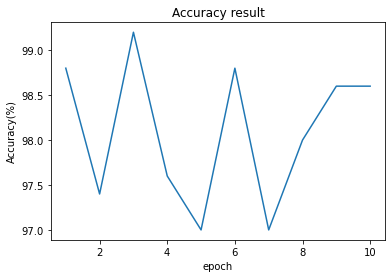

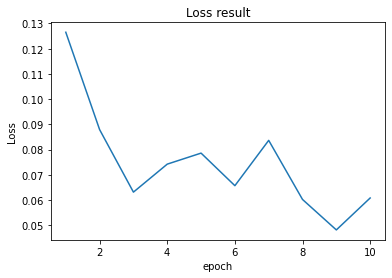

Done!


In [19]:
fit(10, vgg11, loss_fn, optimizer_vgg11)

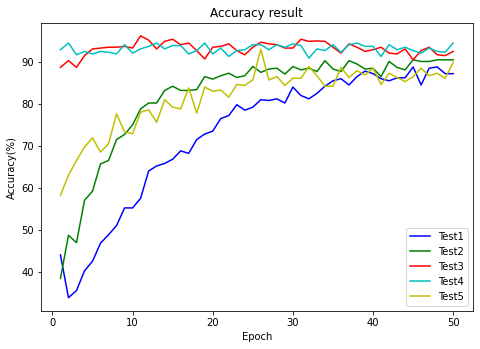

In [2]:
# overall test acc result

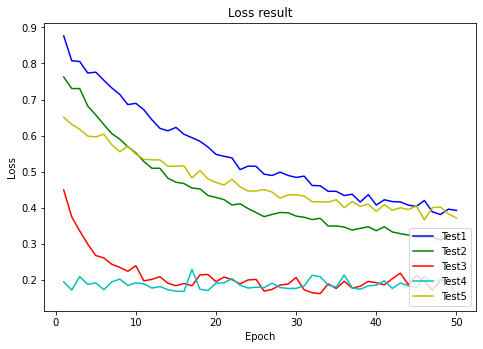

In [3]:
# overall test loss result

Some bad results

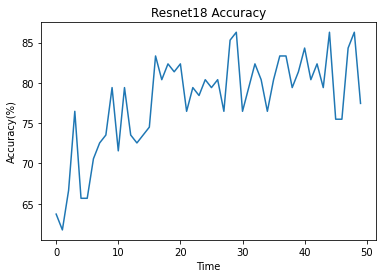

In [37]:
# This is over fitting because using tiny amount of training data(train dataset volume=500)

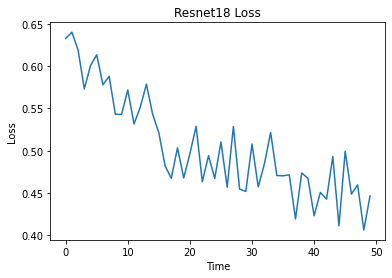

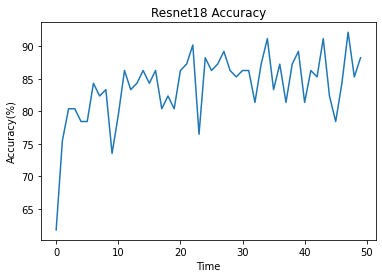

In [74]:
# This is over fitting because the pool quality of datasets(The mask is blurry and strange in the photo, and the face part in the photo is very small)

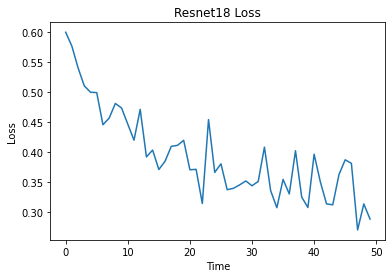

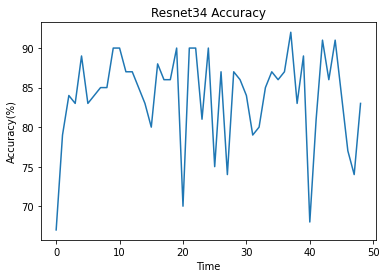

In [141]:
# over fitting, learning rate is too high

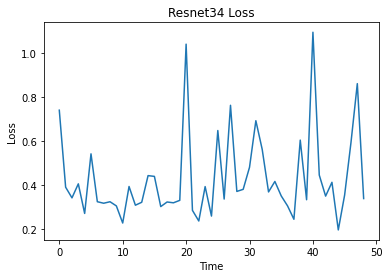

*Discussion:For a data volume of 3000, it is relatively appropriate to use resnet18, use the adam optimizer and set the learning rate of 0.0001. If the learning rate is too high, it may lead to over fitting. With resnet34, because it has a deeper network structure, it will take more training time and require less learning rate. The SGD optimizer may have larger data changes than the Adam optimizer, but because of the momentum, it may skip the local minimum value to reach a new maximum accuracy or minimum loss value.
The weakness of this experiment is that the data used is idealized (lack of side faces, mask types, etc.) and no test training module for inappropriate mask wearing is added.In the future, this experiment can expand the test scope, such as testing more practical test data, testing the impact of epoch size on the experimental results, etc., and if you want to use the camera for real-time testing, you need to add the CascadeClassifier module to extract the face part.